## CNN

In [1]:
#General imports
import os, os.path
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

#Imports for CNN
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#Import for SVM
from sklearn import svm 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#Imports fo Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

#Imports for metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, log_loss
import matplotlib.colors as mcolors

#Generation of seed
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

#Imports for Transfer Learning
import glob

### 2 - Load dataset

In [2]:
result = []

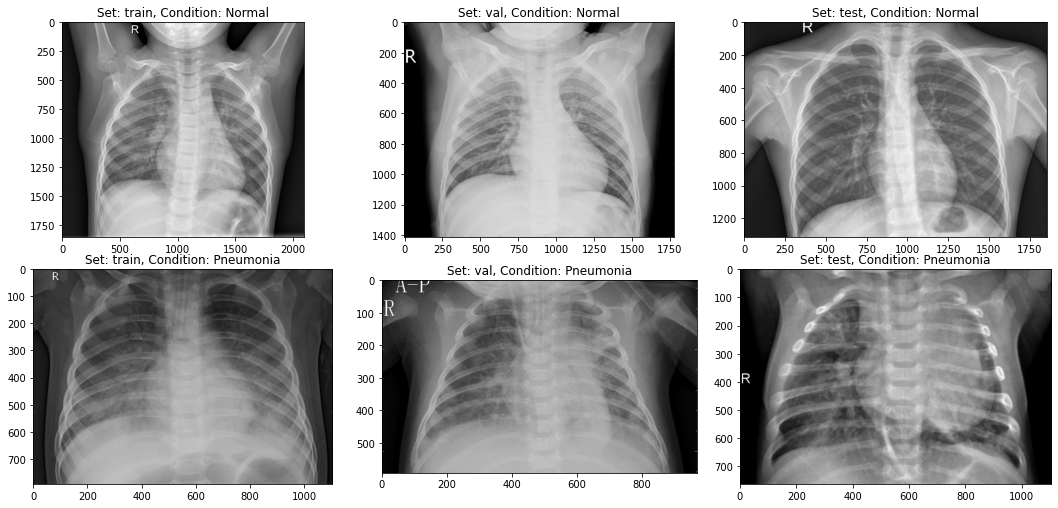

In [26]:
input_path = '../dataset_small/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [27]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 400, pneumonia images: 400
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [28]:
def process_data(img_dims, batch_size):
    # Initialize Data Augmentation
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=False)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Import training set
    train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    # Import testing set
    test_gen = test_val_datagen.flow_from_directory(
        directory=input_path+'test', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    # Import Validation set
    val_gen = test_val_datagen.flow_from_directory(
        directory=input_path+'val', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    test_data = []
    test_labels = []

    # Seperate Test images and labeks
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels, val_gen

In [29]:
def count_image(input_path):
    _set = 'train'
    count_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    count_pneumonia = len(os.listdir(input_path + _set + '/PNEUMONIA'))

    return count_normal, count_pneumonia

In [30]:
img_dims = 150
epochs = 20
batch_size = 32

train_gen, test_gen, test_data, test_labels, val_gen = process_data(img_dims, batch_size)
count_normal, count_pneumonia = count_image(input_path)

Found 800 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### 2 - Create Model

In [31]:
initial_bias = np.log([count_pneumonia/count_normal])
initial_bias

array([0.])

In [32]:
weight_for_0 = (1 / count_normal)*(train_gen.samples)/2.0 
weight_for_1 = (1 / count_pneumonia)*(train_gen.samples)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

final_bias = np.log([weight_for_1 * count_pneumonia/weight_for_0 * count_normal])
print('Final bias: ', final_bias)

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Final bias:  [11.98292909]
Weight for class 0: 1.00
Weight for class 1: 1.00


In [33]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

In [34]:
model = Model(inputs=inputs, outputs=output)

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.AUC(name='AUC')]
    
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [35]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model2.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [36]:
history = model.fit(
            train_gen, 
            steps_per_epoch = train_gen.samples // batch_size, 
            epochs = epochs,
            validation_data = val_gen, 
            validation_steps = val_gen.samples // batch_size, 
            class_weight = class_weight,
            callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/20
25/25 [==============================] - 24s 898ms/step - loss: 0.6679 - accuracy: 0.5675 - precision: 0.5404 - recall: 0.9025 - fn: 39.0000 - fp: 307.0000 - tn: 93.0000 - tp: 361.0000 - AUC: 0.6309
Epoch 2/20
25/25 [==============================] - 19s 757ms/step - loss: 0.3743 - accuracy: 0.8500 - precision: 0.8911 - recall: 0.7975 - fn: 81.0000 - fp: 39.0000 - tn: 361.0000 - tp: 319.0000 - AUC: 0.9008
Epoch 3/20
25/25 [==============================] - 19s 749ms/step - loss: 0.3447 - accuracy: 0.8587 - precision: 0.8997 - recall: 0.8075 - fn: 77.0000 - fp: 36.0000 - tn: 364.0000 - tp: 323.0000 - AUC: 0.9146
Epoch 4/20
25/25 [==============================] - 19s 740ms/step - loss: 0.3262 - accuracy: 0.8825 - precision: 0.9448 - recall: 0.8125 - fn: 75.0000 - fp: 19.0000 - tn: 381.0000 - tp: 325.0000 - AUC: 0.9340
Epoch 5/20
25/25 [==============================] - 19s 738ms/step - loss: 0.2989 - accuracy: 0.8850 - precision: 0.9451 - recall: 0.8175 - fn: 73.0000 - fp: 19

In [37]:
# Evaluating the model on train and test
score_train = model.evaluate(train_gen)

print("Train Loss: ", score_train[0])
print("Train Accuracy: ", score_train[1])

score_test = model.evaluate(test_gen)
print("\nTest loss: ", score_test[0])
print("Test Accuracy: ", score_test[1])

25/25 [==============================] - 12s 465ms/step - loss: 2.2025 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - fn: 0.0000e+00 - fp: 400.0000 - tn: 0.0000e+00 - tp: 400.0000 - AUC: 0.8974
Train Loss:  2.202545404434204
Train Accuracy:  0.5
20/20 [==============================] - 6s 291ms/step - loss: 1.6378 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000 - fn: 0.0000e+00 - fp: 234.0000 - tn: 0.0000e+00 - tp: 390.0000 - AUC: 0.8358

Test loss:  1.6377806663513184
Test Accuracy:  0.625


In [38]:
score_test

[1.6377806663513184,
 0.625,
 0.625,
 1.0,
 0.0,
 234.0,
 0.0,
 390.0,
 0.8357824087142944]

In [39]:
print("Loss:", score_test[0])
print("Acc:", score_test[1])
print("Prec:", score_test[2])
print("Recall:", score_test[3])
print("fn:", score_test[4])
print("fp:", score_test[5])
print("tn:", score_test[6])
print("tp:", score_test[7])
print("AUC:", score_test[8])


Loss: 1.6377806663513184
Acc: 0.625
Prec: 0.625
Recall: 1.0
fn: 0.0
fp: 234.0
tn: 0.0
tp: 390.0
AUC: 0.8357824087142944


In [40]:
score_test.append("score_test_small")
result.append(score_test)

In [41]:
result

[[0.27210092544555664,
  0.8878205418586731,
  0.8524228930473328,
  0.9923076629638672,
  3.0,
  67.0,
  167.0,
  387.0,
  0.9719811081886292,
  'score_test_small'],
 [0.27210092544555664,
  0.8878205418586731,
  0.8524228930473328,
  0.9923076629638672,
  3.0,
  67.0,
  167.0,
  387.0,
  0.9719811081886292,
  'score_test_small_fine_tuning'],
 [1.6377806663513184,
  0.625,
  0.625,
  1.0,
  0.0,
  234.0,
  0.0,
  390.0,
  0.8357824087142944,
  'score_test_small']]

### 3 - Fine Tuning the Model

In [42]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

hist = model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // batch_size,
    epochs=1,
    validation_data = test_gen,
    validation_steps = test_gen.samples // batch_size,
    class_weight = class_weight,
    callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]
)

### 4 - Metrics

In [43]:
# Evaluating the model on train and test
score_train = model.evaluate(train_gen)

print("Train Loss: ", score_train[0])
print("Train Accuracy: ", score_train[1])

score_test = model.evaluate(test_gen)
print("\nTest loss: ", score_test[0])
print("Test Accuracy: ", score_test[1])

25/25 [==============================] - 12s 468ms/step - loss: 2.2054 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - fn: 0.0000e+00 - fp: 400.0000 - tn: 0.0000e+00 - tp: 400.0000 - AUC: 0.8738
Train Loss:  2.2053706645965576
Train Accuracy:  0.5
20/20 [==============================] - 6s 272ms/step - loss: 1.6378 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000 - fn: 0.0000e+00 - fp: 234.0000 - tn: 0.0000e+00 - tp: 390.0000 - AUC: 0.8358

Test loss:  1.6377805471420288
Test Accuracy:  0.625


In [44]:
score_test

[1.6377805471420288,
 0.625,
 0.625,
 1.0,
 0.0,
 234.0,
 0.0,
 390.0,
 0.8357824087142944]

In [45]:
print("Loss:", score_test[0])
print("Acc:", score_test[1])
print("Prec:", score_test[2])
print("Recall:", score_test[3])
print("fn:", score_test[4])
print("fp:", score_test[5])
print("tn:", score_test[6])
print("tp:", score_test[7])
print("AUC:", score_test[8])


Loss: 1.6377805471420288
Acc: 0.625
Prec: 0.625
Recall: 1.0
fn: 0.0
fp: 234.0
tn: 0.0
tp: 390.0
AUC: 0.8357824087142944


In [46]:
score_test.append("score_test_small_fine_tuning")
result.append(score_test)

In [47]:
result

[[0.27210092544555664,
  0.8878205418586731,
  0.8524228930473328,
  0.9923076629638672,
  3.0,
  67.0,
  167.0,
  387.0,
  0.9719811081886292,
  'score_test_small'],
 [0.27210092544555664,
  0.8878205418586731,
  0.8524228930473328,
  0.9923076629638672,
  3.0,
  67.0,
  167.0,
  387.0,
  0.9719811081886292,
  'score_test_small_fine_tuning'],
 [1.6377806663513184,
  0.625,
  0.625,
  1.0,
  0.0,
  234.0,
  0.0,
  390.0,
  0.8357824087142944,
  'score_test_small'],
 [1.6377805471420288,
  0.625,
  0.625,
  1.0,
  0.0,
  234.0,
  0.0,
  390.0,
  0.8357824087142944,
  'score_test_small_fine_tuning']]